## Will Holt & Michael Wise
## DATA 477 Capping
## Chapter 14 Project
## Spring 2023

TO DO:

* Basic drop and relearn and permute and relearn (Will)
* One hot encode variables that need it
  - Manipulate the data, export the manipulated data so it's easy to put in R
* SHAP (https://shap.readthedocs.io/en/latest/index.html) (Mike)
* LIME (https://github.com/marcotcr/lime) (Mike)
* Conditional variable importance (Will)
* Find more datasets

Models:
* Random Forest
* XGBoost
* Neural Network

Other Datasets:
* Heart Disease
* MNIST
* World Happiness Report
* Wine Reviews
* Data Science Job Salaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
heart = pd.read_csv('https://raw.githubusercontent.com/Will-Holt60/Test/master/heart.csv')
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


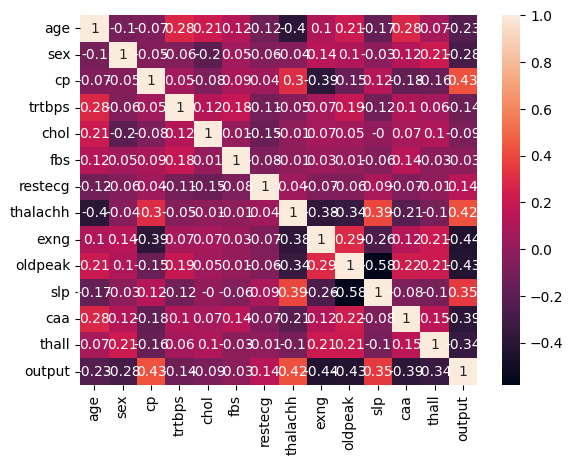

In [ ]:
matrix = heart.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [ ]:
!pip install -Iv rpy2==3.1.0
#run this once or it doesn't work because colab sucks and so does this package lol

In [ ]:
from rpy2 import robjects
values = robjects.r('''
          heart = read.csv('https://raw.githubusercontent.com/Will-Holt60/Test/master/heart.csv')
          heart$sex = factor(heart$sex)
          heart$cp = factor(heart$cp)
          heart$fbs = factor(heart$fbs)
          heart$restecg = factor(heart$restecg)
          heart$exng = factor(heart$exng)
          heart$slp = factor(heart$slp)
          heart$caa = factor(heart$caa)
          heart$thall = factor(heart$thall)
          model <- glm(output~age+sex+cp+trtbps+chol+fbs+restecg+thalachh+exng+oldpeak+slp+caa+thall, family="binomial", data=heart)
          summary(model) 
         ''')

In [ ]:
from rpy2.robjects.packages import importr, data
#utils = importr('utils')
#utils.install_packages('ggplot2')
#ggplot = importr('ggplot2')

In [ ]:
data = pd.DataFrame(data=np.reshape(values[11], (23,4)), columns=values[11].colnames)
data = data.set_index(np.array(values[11].rownames).transpose())
data = data.sort_values(by=['Pr(>|z|)'])
data

,Estimate,Std. Error,z value,Pr(>|z|)
caa1,-2.342301,0.527416,-4.441089,0.000009
caa2,-3.483178,0.811640,-4.291531,0.000018
cp2,2.003186,0.529356,3.784192,0.000154
cp3,2.417107,0.719242,3.360634,0.000778
sex1,-1.862297,0.570844,-3.262356,0.001105
caa3,-2.247144,0.937629,-2.396623,0.016547
trtbps,-0.026162,0.011943,-2.190603,0.028481
exng1,-0.779111,0.451839,-1.724311,0.084652
thalachh,0.020055,0.011859,1.691088,0.090820
oldpeak,-0.397174,0.242346,-1.638875,0.101239


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
#Ignore warnings or change drop and relearn function
#import warnings
#warnings.filterwarnings("ignore")

In [ ]:
y_heart = heart['output']
X_heart = heart.drop('output', axis=1)
numeric_features=[0,3, 4, 7, 9]
categorical_features=[1,2,5,6,8,10,11,12]
clf = LogisticRegression(random_state=0, solver='liblinear',multi_class='ovr')

## Drop and Relearn for Logistic Regression

In [ ]:
def drop_fit(x, y, num, cat, model): 
  cat_xformer = make_pipeline(OneHotEncoder(drop='first'))
  num_xformer = make_pipeline(StandardScaler())

  X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)

  preprocessor = make_column_transformer((num_xformer, num),(cat_xformer, cat))

  pipe = make_pipeline(preprocessor, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_val)
  
  return pd.DataFrame(data = list(zip(y_pred, y_val)), columns = ['y_pred', 'y_val'])

In [ ]:
def drop_learn(x, y, num, cat, model):
  fit = drop_fit(x, y, num, cat, model)
  accuracy = accuracy_score(fit['y_val'], fit['y_pred'])
  ac_df = pd.DataFrame(columns = ['Variable Removed', 'Accuracy'])
  ac_df = ac_df.append({'Variable Removed':'None', 'Accuracy':accuracy}, ignore_index=True)
  for i in range(0, len(x.columns)):
    x_drop = x.drop(x.columns[i], axis=1)

    num_drop = [j for j in num if j != i]
    for j, v in enumerate(num_drop):
      if num_drop[j] > i: 
        num_drop[j] = v-1

    cat_drop = [j for j in cat if j != i]
    for j, v in enumerate(cat_drop):
      if cat_drop[j] > i: 
        cat_drop[j] = v-1

    fit = drop_fit(x_drop, y, num_drop, cat_drop, model)
    ac_score = accuracy_score(fit['y_val'], fit['y_pred'])
    ac_df = ac_df.append({'Variable Removed':x.columns[i], 'Accuracy':ac_score}, ignore_index=True)

    ac_df['Difference'] = ac_df['Accuracy'] - accuracy

  return ac_df.sort_values(by=['Accuracy'], ascending=True)


In [ ]:
dll = drop_learn(X_heart, y_heart, numeric_features, categorical_features, clf)
dll

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,Variable Removed,Accuracy,Difference
12,caa,0.802198,-0.032967
13,thall,0.802198,-0.032967
2,sex,0.824176,-0.010989
0,None,0.835165,0.000000
3,cp,0.835165,0.000000
4,trtbps,0.835165,0.000000
5,chol,0.835165,0.000000
6,fbs,0.835165,0.000000
8,thalachh,0.835165,0.000000
10,oldpeak,0.835165,0.000000


##Drop and Relearn for Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
dlr = drop_learn(X_heart, y_heart, numeric_features, categorical_features, rf)
dlr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,Variable Removed,Accuracy,Difference
12,caa,0.725275,-0.043956
9,exng,0.747253,-0.021978
1,age,0.758242,-0.010989
6,fbs,0.758242,-0.010989
8,thalachh,0.758242,-0.010989
10,oldpeak,0.758242,-0.010989
0,None,0.769231,0.000000
2,sex,0.769231,0.000000
5,chol,0.780220,0.010989
13,thall,0.780220,0.010989


## Permutation importance and MDI (Mean Decrease in Impurity) Tree Feature Importance
* Let's try it with a random forest classifier as it will work for both methodologies.

Make pipeline with one hot encording and standard scaling for the random forest.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_heart, y_heart, test_size=0.3, random_state=0)
rf.fit(X_train, y_train)

In [ ]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_val, y_val):.3f}")

In [ ]:
rf.feature_importances_

array([0.02536766, 0.03620854, 0.18171463, 0.01099842, 0.0154906 ,
       0.00523947, 0.00038648, 0.10502649, 0.13082279, 0.14367954,
       0.04241405, 0.12847886, 0.17417246])

In [ ]:
feature_names = X_heart.columns.values.tolist()

mdi_importances = pd.Series(
    rf.feature_importances_, index=feature_names).sort_values(ascending=True)

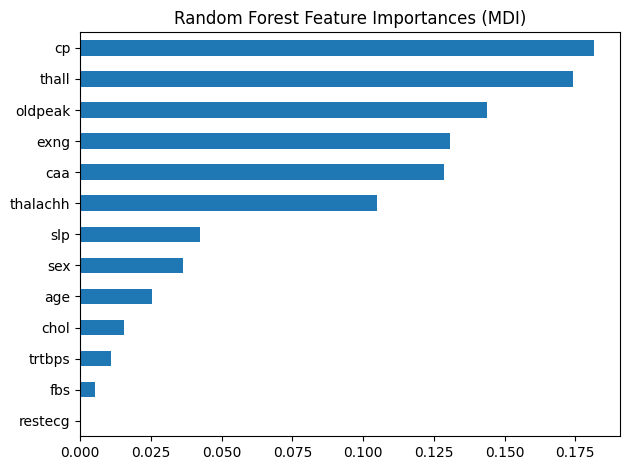

In [ ]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Permutation importance of the same model

In [ ]:
from sklearn.inspection import permutation_importance

train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=0, n_jobs=2) #repeat for 10 times

test_result = permutation_importance(
    rf, X_val, y_val, n_repeats=10, random_state=0, n_jobs=2)

sorted_importances_idx = train_result.importances_mean.argsort()

In [ ]:
train_result

{'importances_mean': array([-0.00424528,  0.00424528,  0.03207547, -0.00283019, -0.00188679,
         0.        ,  0.        ,  0.00330189,  0.00613208,  0.0259434 ,
         0.00707547,  0.03443396,  0.03443396]),
 'importances_std': array([0.00330189, 0.00444999, 0.01427618, 0.00231084, 0.00377358,
        0.        , 0.        , 0.01076671, 0.00762052, 0.0110119 ,
        0.00675369, 0.01076671, 0.01097142]),
 'importances': array([[-0.00943396, -0.00471698,  0.        , -0.00471698, -0.00471698,
         -0.00471698,  0.        , -0.00943396, -0.00471698,  0.        ],
        [ 0.        ,  0.00943396,  0.00943396,  0.00471698,  0.00471698,
          0.00943396,  0.00471698, -0.00471698,  0.00471698,  0.        ],
        [ 0.04245283,  0.02358491,  0.03773585,  0.05188679,  0.04245283,
          0.00943396,  0.00943396,  0.03301887,  0.04716981,  0.02358491],
        [-0.00471698, -0.00471698,  0.        , -0.00471698,  0.        ,
         -0.00471698, -0.00471698, -0.00471698, 

In [ ]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_heart.columns[sorted_importances_idx],)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=X_heart.columns[sorted_importances_idx],)

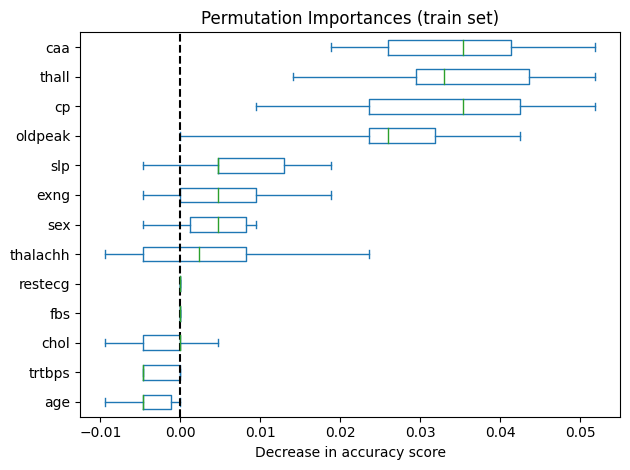

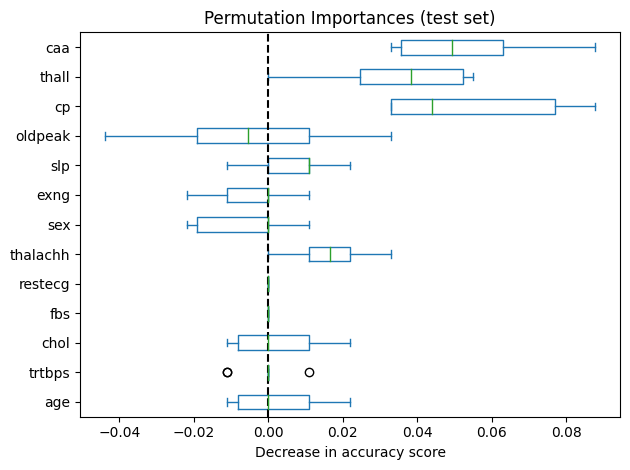

In [ ]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

Other methods:
* SHAP
* LIME
* Conditional Variable Importance

## SHAP Implementation of Random Forest Feature Importance on Heart Disease Data

In [ ]:
!pip install shap

In [ ]:
import shap
#initialize js vizualization
shap.initjs()

In [ ]:
# Fit shap to our random forest

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_heart)

In [ ]:
shap_values[0]

array([[ 0.0074779 ,  0.0105253 , -0.06081426, ...,  0.01055302,
        -0.04880393, -0.02681841],
       [-0.01603779,  0.0111197 , -0.0590357 , ...,  0.00968749,
        -0.0433654 , -0.0531778 ],
       [-0.01573531, -0.02298495, -0.06122672, ..., -0.01911482,
        -0.04017883, -0.05165543],
       ...,
       [ 0.00311488,  0.00976518,  0.0718283 , ...,  0.01698423,
         0.06326594,  0.08597124],
       [ 0.00546427,  0.01291968,  0.07497719, ...,  0.01691471,
         0.06636875,  0.0760385 ],
       [ 0.00728729, -0.02187601, -0.080658  , ...,  0.0148203 ,
         0.05674276, -0.04958308]])

Trying out shap's summary plot feature:

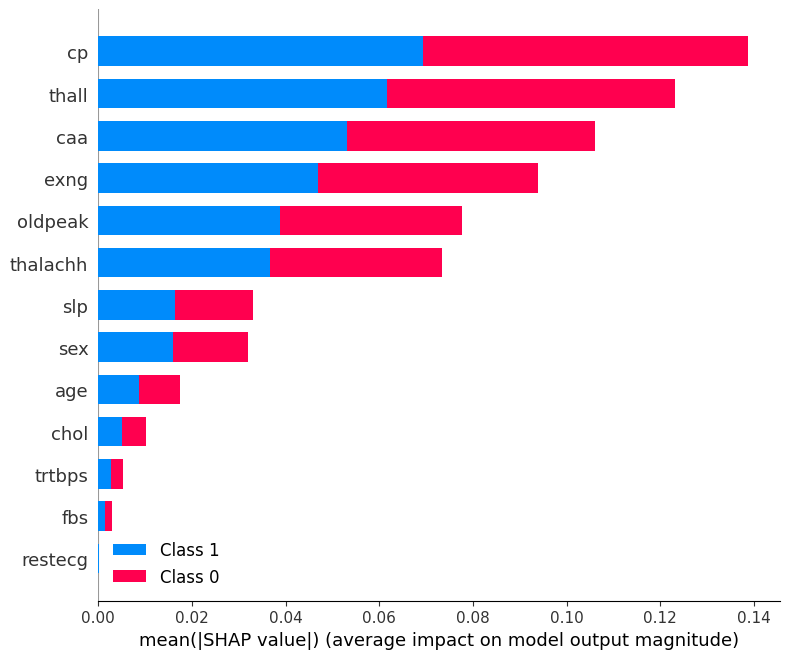

In [ ]:
shap.summary_plot(shap_values, features=X_heart, feature_names=X_heart.columns, plot_type="bar")

## LIME Implementation of Random Forest Feature Importance on Heart Disease Data

In [ ]:
!pip install lime

Lime requires a tabular explainer object to do it's analysis.

TO DO: once all packages we need are sorted, move all installs/import statements to top.

In [ ]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=[0, 1],
    mode='classification'
)

First row only for now : we can expand this analysis to our whole data

In [ ]:
exp = explainer.explain_instance(
    data_row=X_val.iloc[2], 
    predict_fn=rf.predict_proba,
    num_features=13
)

exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


##Lime Mean Weights

In [ ]:
def return_weights(exp):
    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight

In [ ]:
weights = []

#Iterate over rows in feature matrix
#change to random sample to decrease runtime
for i in range(0, len(X_val)):
    
    #Get explanation
    exp = explainer.explain_instance(X_val.iloc[i], predict_fn=rf.predict_proba, num_features=13)
    
    #Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)
    
#Create DataFrame
lime_weights = pd.DataFrame(data=weights,columns=X_heart.columns)

Text(0.5, 0, 'Mean |Weight|')

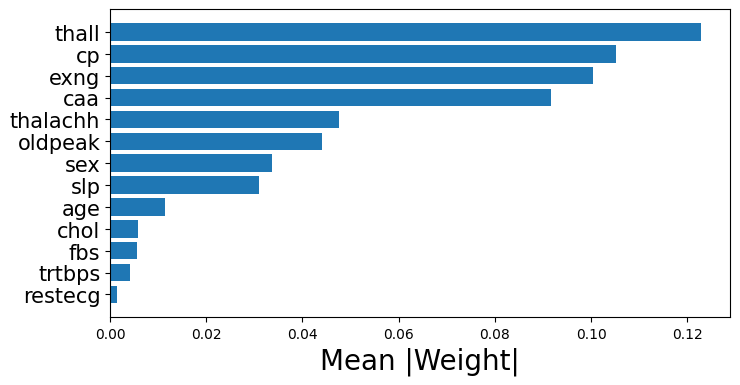

In [ ]:
#Get abs mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

#Plot abs mean
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,4))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature
plt.barh(y=y_ticks,width=abs_mean.abs_mean)

plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
plt.title('')
plt.ylabel('')
plt.xlabel('Mean |Weight|',size=20)

##Comparison

In [ ]:
from string import digits

glm = data.index.values.tolist()

def del_num(str):
  remove_digits = str.maketrans('', '', digits)
  return str.translate(remove_digits)

# define vectorized sigmoid
vector = np.vectorize(del_num)
glm = vector(glm)[:-1]

df = pd.DataFrame(data={'glm':glm, 'index':range(1,len(glm)+1)})
df = df.groupby(['glm']).mean().sort_values(by=['index'])
glm = df.index.values.tolist()

In [ ]:
shp_mean = {'mean1':pd.DataFrame(abs(np.array(shap_values[0]))).mean(),
            'mean2':pd.DataFrame(abs(np.array(shap_values[1]))).mean()}
shp = pd.DataFrame(data=shp_mean)
shp['sum'] = shp['mean1'] + shp['mean2']
shp = shp.assign(names = list(heart.columns[:-1]))
shp = shp.sort_values(by='sum', ascending=False)

In [ ]:
comp = {
    'P-Value': glm,
    'DnR LR':dll['Variable Removed'][dll['Variable Removed'] != 'None'],
    'DnR RF':dlr['Variable Removed'][dlr['Variable Removed'] != 'None'],
    'MDI':mdi_importances.sort_values(ascending=False).index,
    'Permutation':test_importances.median().sort_values(ascending=False).index,
    'SHAP':list(shp['names']),
    'Lime':abs_mean.sort_values(by='abs_mean', ascending=False).index
}

pd.DataFrame(comp)

,P-Value,DnR LR,DnR RF,MDI,Permutation,SHAP,Lime
1,sex,age,age,cp,caa,cp,thall
2,cp,sex,sex,thall,cp,thall,cp
3,caa,cp,cp,oldpeak,thall,caa,exng
4,trtbps,trtbps,trtbps,exng,thalachh,exng,caa
5,exng,chol,chol,caa,slp,oldpeak,thalachh
6,thalachh,fbs,fbs,thalachh,age,thalachh,oldpeak
7,oldpeak,restecg,restecg,slp,trtbps,slp,sex
8,age,thalachh,thalachh,sex,chol,sex,slp
9,chol,exng,exng,age,fbs,age,age
10,restecg,oldpeak,oldpeak,chol,restecg,chol,chol
